# Azure OpenAI Integration

This notebook covers the basics of using an Azure hosted OpenAI LLM in Runway.

In [1]:
import os

from neo4j_runway.llm.openai import AzureOpenAIDiscoveryLLM, AzureOpenAIDataModelingLLM
from neo4j_runway import Discovery, UserInput, GraphDataModeler
import pandas as pd

## Load Data

In [2]:
df = pd.read_csv("../data/countries/countries.csv")

In [3]:
user_input = UserInput(general_description='This is data on different countries.',
                                 column_descriptions={
                                     'id': 'unique id for a country.',
                                    'name': 'the country name.',
                                    'phone_code': 'country area code.',
                                    'capital': 'the capital of the country.',
                                    'currency_name': "name of the country's currency.",
                                    'region': 'primary region of the country.',
                                    'subregion': 'subregion location of the country.',
                                    'timezones': 'timezones contained within the country borders.',
                                    'latitude': 'the latitude coordinate of the country center.',
                                    'longitude': 'the longitude coordinate of the country center.'
                                    },
                                use_cases=[
        "Which region contains the most subregions?", 
        "What currencies are most popular?", 
        "Which countries share timezones?"
    ]  
                                )

## Discovery

In [4]:
disc_llm = AzureOpenAIDiscoveryLLM(model="gpt-4o-runway", # this is the deployment name in Azure OpenAI Studio
                                   model_params={"temperature": 0.5},
                                   azure_open_ai_key=os.environ.get("AZURE_OPENAI_API_KEY"), # this will be auto read from env if present. declaring here for demo.
                                   azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),   # this will be auto read from env if present. declaring here for demo.
                                   azure_ad_token_provider=None, # if using Microsoft Entra ID authentication you can provide credentials here.
                                   ) 

In [5]:
disc = Discovery(llm=disc_llm, data=df, user_input=user_input)

In [6]:
disc.run()

The dataset consists of 250 entries, each representing a country, with 10 features including both numerical and categorical data. Here's a preliminary analysis:

### Important Overall Details:
- **Data Completeness**: The dataset is mostly complete, with minor missing values in the 'capital', 'region', and 'subregion' columns.
- **Unique Identifiers**: Each country has a unique 'id' and 'name'.
- **Geographical Coordinates**: Latitude and longitude are available for all countries, providing geographical context.

### Key Features for Use Cases:
1. **Region and Subregion**:
   - The 'region' and 'subregion' columns are essential for identifying which region contains the most subregions. With 6 unique regions and 22 unique subregions, analysis can be done by grouping and counting entries.

2. **Currency Name**:
   - The 'currency_name' column, with 161 unique values, is crucial for identifying the most popular currencies. The most frequent currency is the Euro.

3. **Timezones**:
   - The 'timezones' column, with 245 unique entries, will help determine which countries share timezones. It contains detailed timezone information that may require further parsing for analysis.

### Most Important Features:
- **Region and Subregion**: For geographical and political grouping.
- **Currency Name**: For economic analysis and identifying currency prevalence.
- **Timezones**: For understanding temporal relationships and shared time zones between countries.

### Additional Observations:
- **Phone Code and Capital**: While not directly related to the use cases, these features provide additional context about the countries.
- **Distribution of Geographical Coordinates**: The latitude and longitude distributions indicate a diverse global representation of countries.

These insights provide a foundational understanding of the dataset, which will aid in designing a graph data model to address the specified use cases.

## Data Modeling

In [11]:
dm_llm = AzureOpenAIDataModelingLLM(model="gpt-4o-runway", # this is the deployment name in Azure OpenAI Studio
                                   model_params={"temperature": 0.0},
                                   azure_open_ai_key=os.environ.get("AZURE_OPENAI_API_KEY"), # this will be auto read from env if present. declaring here for demo.
                                   azure_endpoint=os.environ.get("AZURE_OPENAI_ENDPOINT"),   # this will be auto read from env if present. declaring here for demo.
                                   azure_ad_token_provider=None, # if using Microsoft Entra ID authentication you can provide credentials here.
                                   )

In [12]:
gdm = GraphDataModeler(discovery=disc, llm=dm_llm)

In [13]:
gdm.create_initial_model(max_retries=2)

Entity Pool Generation Attempt: 1
nodes : ['Country', 'Region', 'Subregion', 'Currency', 'Timezone']
rels  : ['BELONGS_TO_REGION', 'BELONGS_TO_SUBREGION', 'USES_CURRENCY', 'HAS_TIMEZONE']
Received Valid Entity Pool.
recieved a valid response


DataModel(nodes=[Node(label='Country', properties=[Property(name='id', type='str', column_mapping='id', alias=None, is_unique=True, part_of_key=False), Property(name='name', type='str', column_mapping='name', alias=None, is_unique=False, part_of_key=False), Property(name='phoneCode', type='str', column_mapping='phone_code', alias=None, is_unique=False, part_of_key=False), Property(name='capital', type='str', column_mapping='capital', alias=None, is_unique=False, part_of_key=False), Property(name='latitude', type='float', column_mapping='latitude', alias=None, is_unique=False, part_of_key=False), Property(name='longitude', type='float', column_mapping='longitude', alias=None, is_unique=False, part_of_key=False)], source_name='file'), Node(label='Region', properties=[Property(name='region', type='str', column_mapping='region', alias=None, is_unique=True, part_of_key=False)], source_name='file'), Node(label='Subregion', properties=[Property(name='subregion', type='str', column_mapping='su

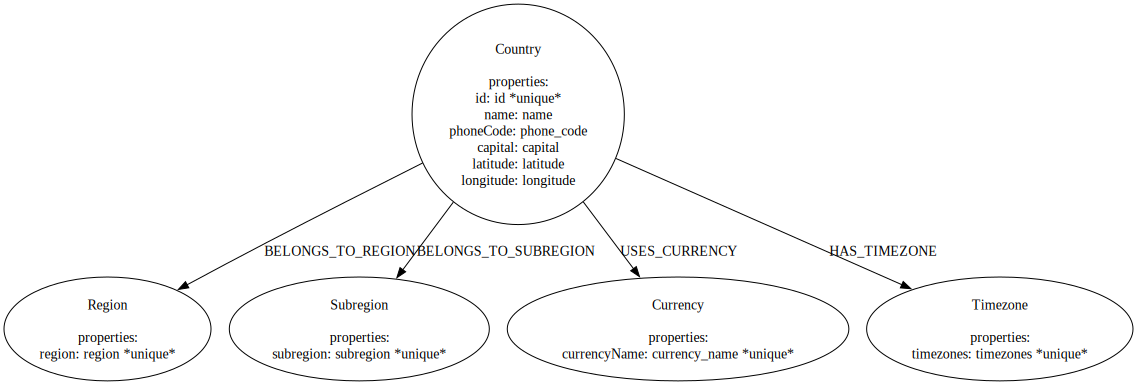

In [14]:
gdm.current_model.visualize()